# Introduction



<img src="https://i.imgur.com/HRhd2Y0.png" width="1000" height="600"/>

# Setup


## Install dependencies

In [ ]:
! pip install pandas
! pip install numpy
! pip install matplotlib
! pip install pyarrow
! pip install requests
! pip install squarify
! pip install surprise
! pip install -U scikit-learn
! pip install seaborn

## Import libraries

In [1]:
# Data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import squarify

# Micellaneous
import requests
import json
from datetime import datetime


# Machine learning

from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from surprise import NormalPredictor, Reader, Dataset, accuracy, SVD
from surprise.model_selection import GridSearchCV, train_test_split

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import adjusted_rand_score


## Load data

In [2]:
customers_ds_url = 'https://raw.githubusercontent.com/galvaowesley/ollist_brazilian_ecommerce_products_recommendation_system/main/data/olist_customers_dataset.csv'
geolocation_ds_url = 'https://raw.githubusercontent.com/galvaowesley/ollist_brazilian_ecommerce_products_recommendation_system/main/data/olist_geolocation_dataset.csv'
order_items_ds_url = 'https://raw.githubusercontent.com/galvaowesley/ollist_brazilian_ecommerce_products_recommendation_system/main/data/olist_order_items_dataset.csv'
order_payments_ds_url = 'https://raw.githubusercontent.com/galvaowesley/ollist_brazilian_ecommerce_products_recommendation_system/main/data/olist_order_payments_dataset.csv'
order_reviews_ds_url = 'https://raw.githubusercontent.com/galvaowesley/ollist_brazilian_ecommerce_products_recommendation_system/main/data/olist_order_reviews_dataset.csv'
oders_ds = 'https://raw.githubusercontent.com/galvaowesley/ollist_brazilian_ecommerce_products_recommendation_system/main/data/olist_orders_dataset.csv'
products_ds_url = 'https://raw.githubusercontent.com/galvaowesley/ollist_brazilian_ecommerce_products_recommendation_system/main/data/olist_products_dataset.csv'



customers_ds = pd.read_csv(customers_ds_url, sep=',')
geolocation_ds = pd.read_csv(geolocation_ds_url, sep=',')
order_items_ds = pd.read_csv(order_items_ds_url, sep=',')
order_payments_ds = pd.read_csv(order_payments_ds_url, sep=',')
order_reviews_ds = pd.read_csv(order_reviews_ds_url, sep=',')
order_ds = pd.read_csv(oders_ds, sep=',')
products_ds = pd.read_csv(products_ds_url, sep=',')

## Dataset Overview

In [3]:
# show the data without truncating
pd.set_option('display.max_colwidth', None)

In [4]:
def dataset_info(datasets, names):
    """
    This function receives a list of DataFrames and a list of names for each DataFrame and returns a DataFrame with useful information about all datasets.

    Parameters:
    --------
    datasets: list of DataFrames
    names: list of strings

    Returns:
    --------
        DataFrame: a DataFrame with useful information about all datasets
    """

    # Creating a DataFrame with useful information about all datasets
    data_info = pd.DataFrame({})
    data_info['dataset'] = names
    data_info['n_rows'] = [df.shape[0] for df in datasets]
    data_info['n_cols'] = [df.shape[1] for df in datasets]


    # Creating a separate DataFrame for columns
    columns_info = pd.concat([pd.DataFrame({'dataset': name, 'column': df.columns}) for name, df in zip(names, datasets)], ignore_index=True)
    # Creating a column with the data type for each column, respectively
    columns_info['dtype'] = [datasets[names.index(row['dataset'])][row['column']].dtype for i, row in columns_info.iterrows()]
    # creating a column with the number of null values for each column
    columns_info['null registers'] = [datasets[names.index(row['dataset'])][row['column']].isnull().sum() for i, row in columns_info.iterrows()]
    # creating a column with the percentage of null values for each column
    columns_info['null_%'] = [round(datasets[names.index(row['dataset'])][row['column']].isnull().mean() * 100, 2) for i, row in columns_info.iterrows()]
    # Unique values for each column
    columns_info['unique'] = [datasets[names.index(row['dataset'])][row['column']].nunique() for i, row in columns_info.iterrows()]
    # Duplicate values for each column
    columns_info['duplicates'] = [datasets[names.index(row['dataset'])][row['column']].duplicated().sum() for i, row in columns_info.iterrows()]
    # Merging the two DataFrames
    final_data_info = pd.merge(data_info, columns_info, on='dataset')
    # Mean for numerical columns only
    final_data_info['mean'] = [datasets[names.index(row['dataset'])][row['column']].mean() if datasets[names.index(row['dataset'])][row['column']].dtype in ['int64', 'float64'] else None for i, row in final_data_info.iterrows()]
    # Minimum for numerical columns only
    final_data_info['min'] = [datasets[names.index(row['dataset'])][row['column']].min() if datasets[names.index(row['dataset'])][row['column']].dtype in ['int64', 'float64'] else None for i, row in final_data_info.iterrows()]
    # Median for numerical columns only
    final_data_info['median'] = [datasets[names.index(row['dataset'])][row['column']].median() if datasets[names.index(row['dataset'])][row['column']].dtype in ['int64', 'float64'] else None for i, row in final_data_info.iterrows()]
    # Maximum for numerical columns only
    final_data_info['max'] = [datasets[names.index(row['dataset'])][row['column']].max() if datasets[names.index(row['dataset'])][row['column']].dtype in ['int64', 'float64'] else None for i, row in final_data_info.iterrows()]
    # Setting multiple columns as indexes
    final_data_info.set_index(['dataset', 'n_rows', 'n_cols', 'column'], inplace=True)
    final_data_info

    return final_data_info


datasets = [customers_ds, geolocation_ds, order_ds,  order_items_ds, products_ds, order_payments_ds, order_reviews_ds]
names = ['customers_ds', 'geolocation_ds', 'order_ds', 'order_items_ds', 'products_ds', 'order_payments_ds', 'order_reviews_ds']

dataset_info(datasets, names)

dtype  \
dataset           n_rows  n_cols column                                   
customers_ds      99441   5      customer_id                     object   
                                 customer_unique_id              object   
                                 customer_zip_code_prefix         int64   
                                 customer_city                   object   
                                 customer_state                  object   
geolocation_ds    1000163 5      geolocation_zip_code_prefix      int64   
                                 geolocation_lat                float64   
                                 geolocation_lng                float64   
                                 geolocation_city                object   
                                 geolocation_state               object   
order_ds          99441   8      order_id                        object   
                                 customer_id                     object   
                                 order_status                    object   
                                 order_purchase_timestamp        object   
                                 order_approved_at               object   
                                 order_delivered_carrier_date    object   
                                 order_delivered_customer_date   object   
                                 order_estimated_delivery_date   object   
order_items_ds    112650  7      order_id                        object   
                                 order_item_id                    int64   
                                 product_id                      object   
                                 seller_id                       object   
                                 shipping_limit_date             object   
                                 price                          float64   
                                 freight_value                  float64   
products_ds       32951   9      product_id                      object   
                                 product_category_name           object   
                                 product_name_lenght            float64   
                                 product_description_lenght     float64   
                                 product_photos_qty             float64   
                                 product_weight_g               float64   
                                 product_length_cm              float64   
                                 product_height_cm              float64   
                                 product_width_cm               float64   
order_payments_ds 103886  5      order_id                        object   
                                 payment_sequential               int64   
                                 payment_type                    object   
                                 payment_installments             int64   
                                 payment_value                  float64   
order_reviews_ds  99224   7      review_id                       object   
                                 order_id                        object   
                                 review_score                     int64   
                                 review_comment_title            object   
                                 review_comment_message          object   
                                 review_creation_date            object   
                                 review_answer_timestamp         object   

                                                                null registers  \
dataset           n_rows  n_cols column                                          
customers_ds      99441   5      customer_id                                 0   
                                 customer_unique_id                          0   
                                 customer_zip_code_prefix                    0   
                                 customer_city         

## Create a core dataframe

Here we will create a core dataframe that merge the main dataframe, order_ds, with the others relevants dataframes by the key columns.

In [5]:
# merge order_merged with customers_ds
order_merged = order_ds.merge(customers_ds, on='customer_id', how='left')
# merge order_ds with order_items_ds
order_merged = order_merged.merge(order_items_ds, on='order_id', how='left')
# merge order_merged with products_ds
order_merged = order_merged.merge(products_ds, on='product_id', how='left')
# merge order_merged with order_reviews_ds
order_merged = order_merged.merge(order_reviews_ds, on='order_id', how='left')
# merge order_merged with order_payments_ds
order_merged = order_merged.merge(order_payments_ds, on='order_id', how='left')


dataset_info([order_merged], ['order_merged'])

dtype  \
dataset      n_rows n_cols column                                   
order_merged 119143 36     order_id                        object   
                           customer_id                     object   
                           order_status                    object   
                           order_purchase_timestamp        object   
                           order_approved_at               object   
                           order_delivered_carrier_date    object   
                           order_delivered_customer_date   object   
                           order_estimated_delivery_date   object   
                           customer_unique_id              object   
                           customer_zip_code_prefix         int64   
                           customer_city                   object   
                           customer_state                  object   
                           order_item_id                  float64   
                           product_id                      object   
                           seller_id                       object   
                           shipping_limit_date             object   
                           price                          float64   
                           freight_value                  float64   
                           product_category_name           object   
                           product_name_lenght            float64   
                           product_description_lenght     float64   
                           product_photos_qty             float64   
                           product_weight_g               float64   
                           product_length_cm              float64   
                           product_height_cm              float64   
                           product_width_cm               float64   
                           review_id                       object   
                           review_score                   float64   
                           review_comment_title            object   
                           review_comment_message          object   
                           review_creation_date            object   
                           review_answer_timestamp         object   
                           payment_sequential             float64   
                           payment_type                    object   
                           payment_installments           float64   
                           payment_value                  float64   

                                                          null registers  \
dataset      n_rows n_cols column                                          
order_merged 119143 36     order_id                                    0   
                           customer_id                                 0   
                           order_status                                0   
                           order_purchase_timestamp                    0   
                           order_approved_at                         177   
                           order_delivered_carrier_date             2086   
                           order_delivered_customer_date            3421   
                           order_estimated_delivery_date               0   
                           customer_unique_id                          0   
                           customer_zip_code_prefix                    0   
                           customer_city                               0   
                           customer_state                              0   
                           order_item_id                             833   
                           product_id                                833   
                           seller_id                                 833   
                           shipping_limit_date                       833   
                           price                                     

---
# Stage 1 - Analysis of orders and customers segments
---

## Orders Analysis

### Evolution of orders over time and geographic region share

To understand the evolution of orders over time, we can plot the number of orders per month and the geographic region share of orders. For this, first we have to get the geographic region of each stats from Brazil by an API.

In [6]:
# stablisihing a connection with the IBGE API
r = requests.get('https://servicodados.ibge.gov.br/api/v1/localidades/mesorregioes')
# getting the content of the request
data = [c['UF'] for c in json.loads(r.text)]
# creating a DataFrame with the data
brazil_regions = pd.DataFrame(data)
# selecting only the columns of interest
brazil_regions['regiao'] = brazil_regions['regiao'].apply(lambda x: x['nome'])
brazil_regions.drop_duplicates(inplace=True)
# drop id column
brazil_regions.drop(columns=['id'], inplace=True)
# rename the columns
brazil_regions.columns = ['uf', 'state_name', 'region']
brazil_regions.sample(5)

,uf,state_name,region
25,PI,Piauí,Nordeste
62,MG,Minas Gerais,Sudeste
84,SP,São Paulo,Sudeste
16,AP,Amapá,Norte
99,PR,Paraná,Sul


Now, let's merge the previous data with the order dataframe.

In [7]:
# merge the order_merged with the brazil_regions
order_merged = order_merged.merge(brazil_regions, left_on='customer_state', right_on='uf', how='left')
# drop uf column
order_merged.drop(columns=['uf'], inplace=True)
order_merged[['order_id','customer_state', 'region']].sample(5)

,order_id,customer_state,region
5038,6b82f79b806b4374a7b1315d1881d1ba,RJ,Sudeste
1326,efb6d19e3c56fa371d59421e45e53a49,SP,Sudeste
90206,5df41d8270624e3bcd155e2803cd3fea,PR,Sul
12278,1a82675c731e609f7adc4c93898a6321,SP,Sudeste
21094,c8fc63e28cfdb28172db4303396499ed,SP,Sudeste


We can also format the date column to datetime format and create a new column with the month and year of the order.

In [8]:
# Formatting the date columns
order_merged['order_purchase_timestamp'] = pd.to_datetime(order_merged['order_purchase_timestamp'])
order_merged['order_purchase_date'] = order_merged['order_purchase_timestamp'].dt.date
order_merged['order_purchase_year_month'] = order_merged['order_purchase_timestamp'].apply(lambda x: x.strftime('%y-%m'))

Seeing the evolution of orders over time, we can see that the number of orders has been increasing with relevance since 2017, with a peak in november 2017, probably due to the black friday. However, there is sudden drop in september 2018, which could be due to some external factor.

Text(0, 0.5, 'Orders')

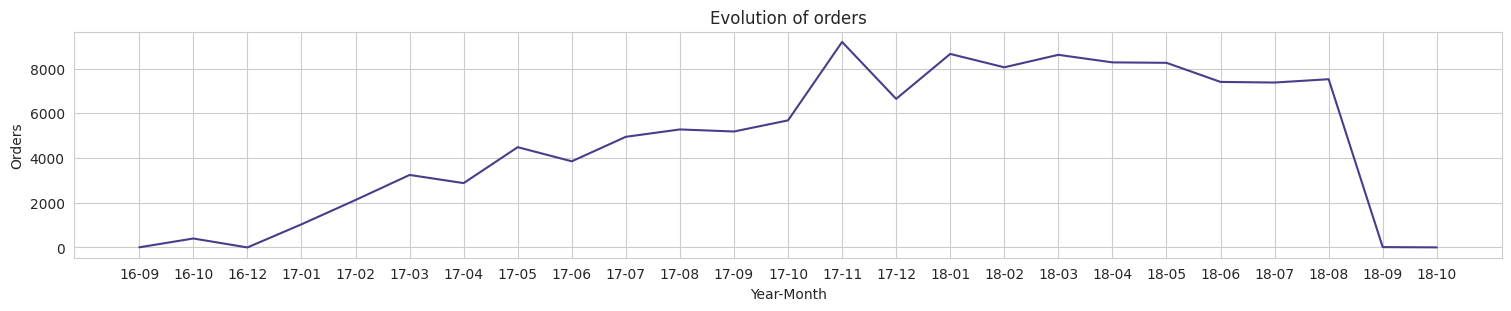

In [9]:
plt.figure(constrained_layout=True, figsize=(15, 3))
# Plotting the number of orders in each region for each year-month
sns.lineplot(data=order_merged['order_purchase_year_month'].value_counts().sort_index(), color='darkslateblue')
# change the size of the plot
plt.title('Evolution of orders')
# xlabel
plt.xlabel('Year-Month')
# ylabel
plt.ylabel('Orders')

Because of these behaviors on extreme periods, we can see that the best period to analyze the data is from 2017 to august 2018.

In [10]:
# filter the data to get only the year 2017
order_merged_filtered = order_merged[(order_merged['order_purchase_year_month'] >= '17-01') & (order_merged['order_purchase_year_month'] < '18-09')]

Grouping the orders by region, state and city, we can plot the number of orders per month and the geographic region share of orders.

In [11]:
# Grouping orders by year-month and region. Aggregating by count of orders and payment_value
region_orders = order_merged_filtered.groupby(['order_purchase_year_month', 'region']).agg({'order_id': 'count'}).reset_index()
# renaming the columns
region_orders.columns = ['order_purchase_year_month', 'region', 'orders']
# Share of orders in each region for each year-month
region_orders['total_orders_month'] = region_orders.groupby('order_purchase_year_month')['orders'].transform('sum')
region_orders['share_month'] = 100*region_orders['orders'] / region_orders['total_orders_month']


# Grouping orders by year-month and state
state_orders = order_merged_filtered.groupby(['order_purchase_year_month', 'customer_state']).agg({'order_id': 'count'}).reset_index()

# Grouping orders by year-month and city
city_orders = order_merged_filtered.groupby(['order_purchase_year_month', 'customer_city']).agg({'order_id': 'count'}).reset_index()

# Grouping orders by year-month, region and product_category_name
region_category_orders = order_merged_filtered.groupby(['order_purchase_year_month', 'region', 'product_category_name']).agg({'order_id': 'count'}).reset_index()

Text(0, 0.5, 'Share of orders (%)')

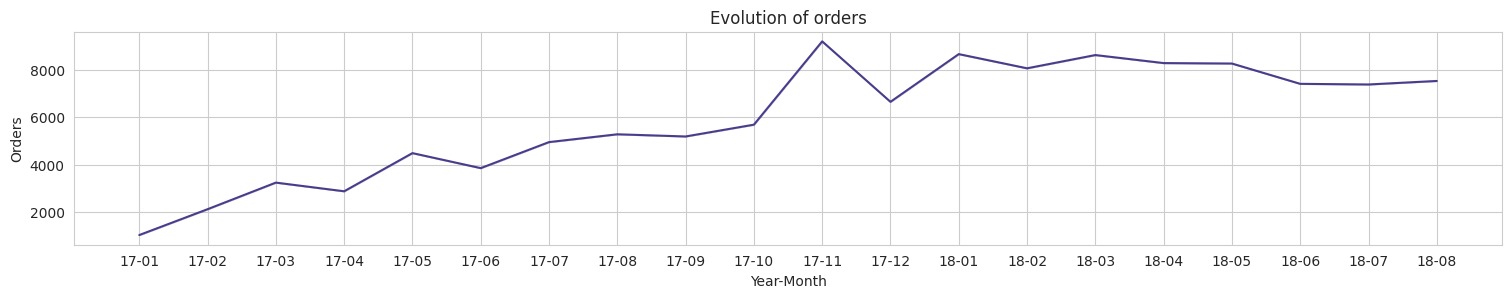

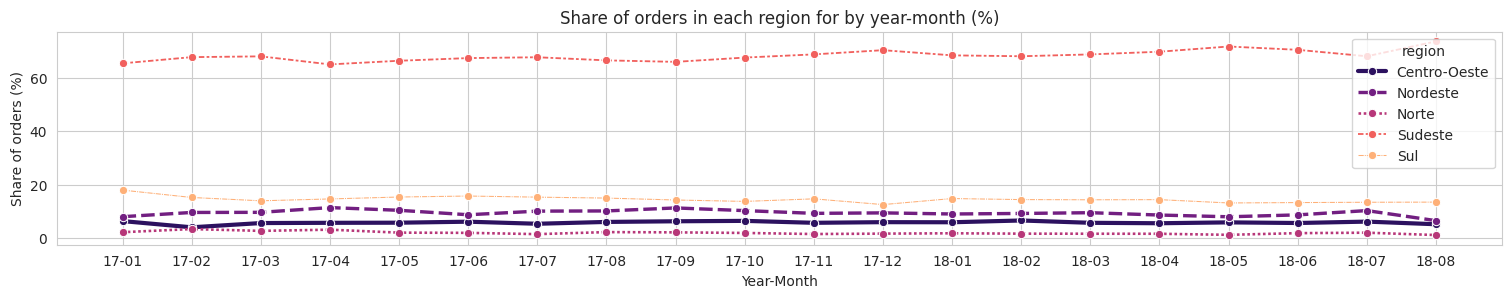

In [12]:
plt.figure(constrained_layout=True, figsize=(15, 5))
# subplot 1
plt.subplot(2, 1, 1)
# Plotting the number of orders in each region for each year-month
sns.lineplot(data=region_orders, x='order_purchase_year_month', y='total_orders_month', color='darkslateblue', markers=['o'] * 5)
# change the size of the plot
plt.title('Evolution of orders')
# xlabel
plt.xlabel('Year-Month')
# ylabel
plt.ylabel('Orders')

plt.figure(constrained_layout=True, figsize=(15, 5))
plt.subplot(2, 1, 2)
# Plotting the share of orders in each region for each year-month
sns.lineplot(data=region_orders, x='order_purchase_year_month', y='share_month', hue='region', size='region', style='region', palette='magma', markers=['o'] * 5)
# change the size of the plot
plt.title('Share of orders in each region for by year-month (%)')
# xlabel
plt.xlabel('Year-Month')
# ylabel
plt.ylabel('Share of orders (%)')

## Considerations

---
# Stage 2 - User segmentation
---

## Segmentation by RFM


RFM (Recency, Frequency, Monetary) analysis is a customer segmentation technique that uses past purchase behavior to divide customers into groups. RFM helps divide customers into various categories or clusters to identify customers who are more likely to respond to promotions and also for future personalization services.

* Recency (R): Who have purchased recently? Number of days since last purchase (least recency)
* Frequency (F): Who has purchased frequently? It means the total number of purchases. (high frequency)
* Monetary Value (M): Who have high purchase amount? It means the total money customer spent (high monetary value)

We can calculate the RFM values for each customer and then segment them into different groups based on these values.

**Customer score**

The customer score ranges from 1 to 5, with 5 being the best score. The score is calculated based on the RFM values as follows:

* Recency: 5 - The customer made a purchase recently
* Frequency: 5 - The customer made frequent purchases
* Monetary Value: 5 - The customer spent a lot of money



Sources:
1. https://documentation.bloomreach.com/engagement/docs/rfm-segmentation
2. https://blog.rsquaredacademy.com/customer-segmentation-using-rfm-analysis/
3. https://medium.com/maxmilhas-tech/o-que-%C3%A9-rfm-e-como-aplic%C3%A1-lo-ao-seu-time-de-customer-service-b9c35817ed01
   

### Data Preparation

First, we will check only orders with status delivered, to consider the orders that were actually completed.

In [13]:
def summary_category(df, feature):
    """
    Calculate the amount of occurrences of each category level in dataset, as well their
    proportion.

    Parameters
    ----------
    df : pandas.DataFrame
    feature : a categorical column of from df

    Returns
    ----------
    df_aux : pandas.DataFrame
    """

    s = df[feature].copy()
    # Count the occurrences of each category level
    counts = s.value_counts()
    # Calculate the proportion of occurrences
    percent100 = s.value_counts(normalize=True).mul(100).round(3)
    # Build a dataframe
    df_aux = pd.DataFrame({'Count': counts, '%': percent100})
    # Set a title
    index = df_aux.index
    index.name = feature

    df_aux = df_aux.reset_index(level=0)

    return df_aux

As we can see, the delivered orders are the majoraty, corresponding to 97% of the orders.

In [14]:
summary_category(order_ds, 'order_status')

,order_status,Count,%
0,delivered,96478,97.020
1,shipped,1107,1.113
2,canceled,625,0.629
3,unavailable,609,0.612
4,invoiced,314,0.316
5,processing,301,0.303
6,created,5,0.005
7,approved,2,0.002


In [15]:
# Filtering only the orders that have been delivered
order_merged_delivered = order_merged_filtered[order_merged_filtered['order_status'] == 'delivered']

It's important to define the date of the last order transaction, since the this dataset has data until the end of 2018. So, we will consider the last date of the dataset as the reference date. Remember that the dataset had been filtered previously to consider registers only until august 2018.

In [16]:
# Get last transaction date to help calculate Recency
max_trans_date = max(order_merged_filtered.order_purchase_timestamp).date()
max_trans_date

datetime.date(2018, 8, 31)

### Recency, Frequency and Monetary Value

Now, let's create the RFM dataframe, by joining the customers dataframe with the order dataframe and then calculate the RFM values for each customer.

In [17]:

# Group orders by customer_unique_id and aggregating by the sum of payment_value, count of product_id and the last purchase date
customers_rfm = order_merged_filtered.groupby('customer_unique_id').agg(
    {
    # difference between the last purchase date and the last transaction date
    'order_purchase_timestamp': lambda x:(datetime.strptime(str(max_trans_date),'%Y-%m-%d') - x.max()).days,
    'order_id': lambda x:len(x), # count of order_ids
    'payment_value': lambda x:sum(x)} # sum of payment_value
    )
# renaming the columns
customers_rfm.columns = ['recency', 'frequency', 'monetary']


In [18]:
customers_rfm.sample(5)

,recency,frequency,monetary
customer_unique_id,,,
8801f29ecc73d133bbff0191a795fc24,180,1,54.60
16c4953da648eeb4821d66403ebcb632,42,1,97.26
30344e4168de593673fc8a3d5f2c8877,263,6,533.61
b1ce37549de270226c9572f7f416ec98,120,1,67.05
94079f2d892bc75e6fca7e2cdb792d6e,80,1,113.77


#### Plot recency, frequency and monetary value distributions

In order to visualize the distribution of the RFM values, we can plot the histograms of the recency, frequency and monetary value. Also, we can see the occurrence of outliers in the data.

In [19]:
def plot_RFM_distribution(df):
    # Plot histograms
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    # Plotting the Recency distribution
    sns.histplot(df['recency'], kde=True, ax=ax[0], color='darkslateblue')
    ax[0].set_title('Recency distribution')

    sns.histplot(df['frequency'], kde=True, ax=ax[1], color='darkslateblue')
    ax[1].set_title('Frequency distribution')

    sns.histplot(df['monetary'], kde=True, ax=ax[2], color='darkslateblue')
    ax[2].set_title('Monetary distribution')

    # Plot stripplot
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    sns.stripplot(data=df['recency'], ax=ax[0], color='darkslateblue')
    ax[0].set_title('Recency distribution')

    sns.stripplot(data=df['frequency'], ax=ax[1], color='darkslateblue')
    ax[1].set_title('Frequency distribution')

    sns.stripplot(data=df['monetary'], ax=ax[2], color='darkslateblue')
    ax[2].set_title('Monetary distribution')



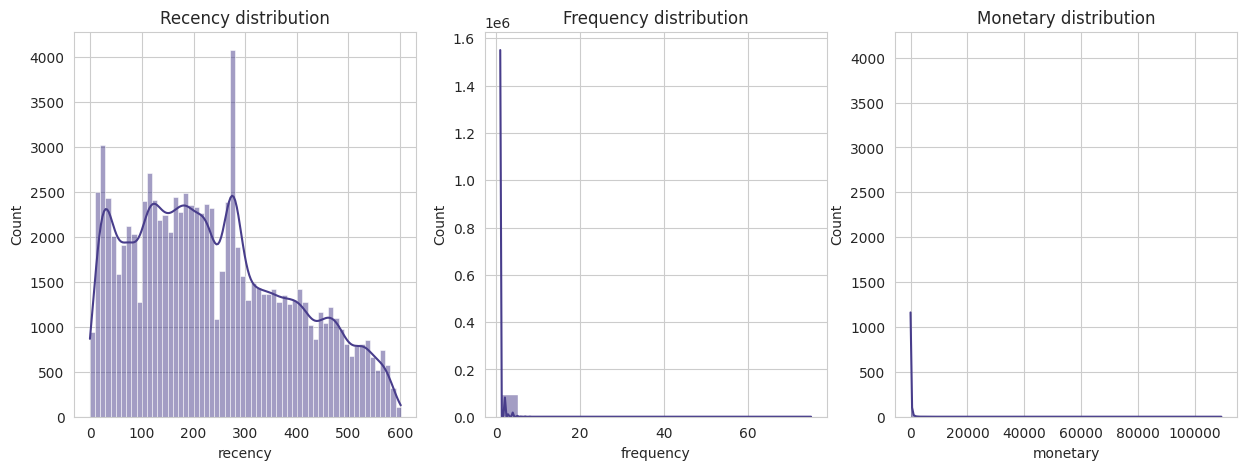

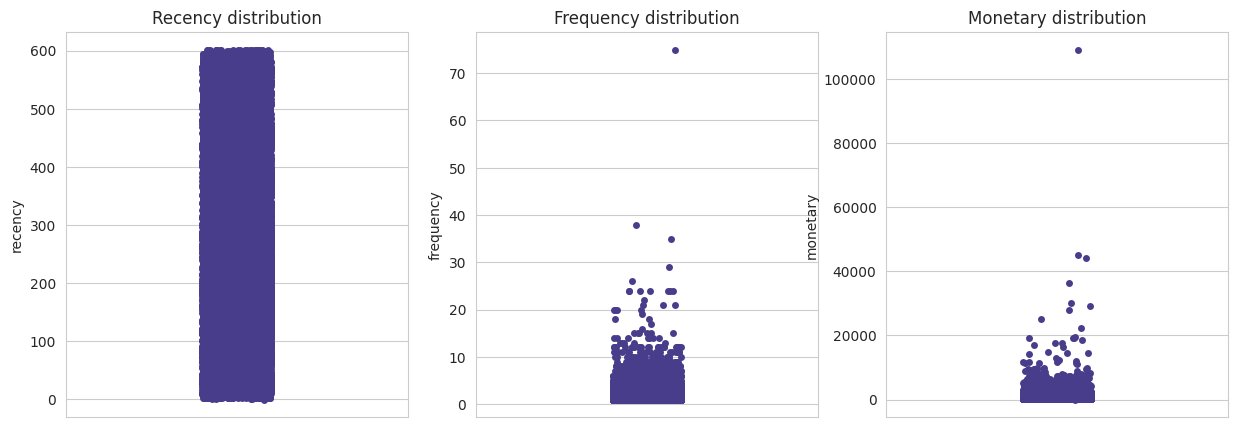

In [20]:
plot_RFM_distribution(customers_rfm)

#### Outliers treatment

As we saw in the previous plots, there are some outliers in the data, present in the frequency and monetary value. We can treat these outliers by removing the values that are above the 99.99th percentile.

In [21]:
# Show the descriptive statistics and its percentiles
customers_rfm.describe(percentiles=[0.025, 0.05, 0.95, 0.999])

,recency,frequency,monetary
count,95774.000000,95774.000000,95774.000000
mean,238.636091,1.239522,214.021213
std,151.431042,0.853049,645.578019
min,-1.000000,1.000000,0.000000
2.5%,15.000000,1.000000,27.750000
5%,24.000000,1.000000,32.700000
50%,220.000000,1.000000,113.330000
95%,519.000000,2.000000,667.993500
99.9%,592.000000,10.000000,6006.122400
max,602.000000,75.000000,109312.640000


In [22]:
def remove_outliers(df, columns, upper_percentile):
    """
    Remove outliers from a DataFrame based on the upper percentile.

    Parameters
    ----------
    df : pandas.DataFrame
    columns : list
    upper_percentile : float

    Returns
    ----------
    df : pandas.DataFrame
    """

    for column in columns:
        upper = df[column].quantile(upper_percentile)
        df = df[df[column] <= upper]

    return df


In [23]:
# Removing outliers from the customers_rfm dataframe
# customers_rfm_treated = remove_outliers(customers_rfm, ['frequency', 'monetary'], 0.999)
customers_rfm_treated = customers_rfm.copy()


In [24]:
customers_rfm.shape, customers_rfm_treated.shape

((95774, 3), (95774, 3))

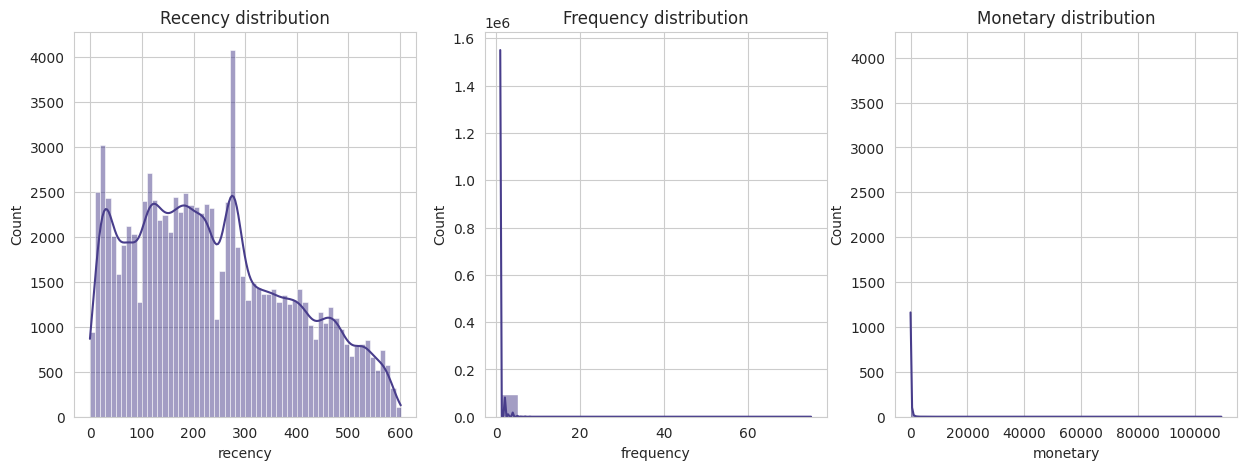

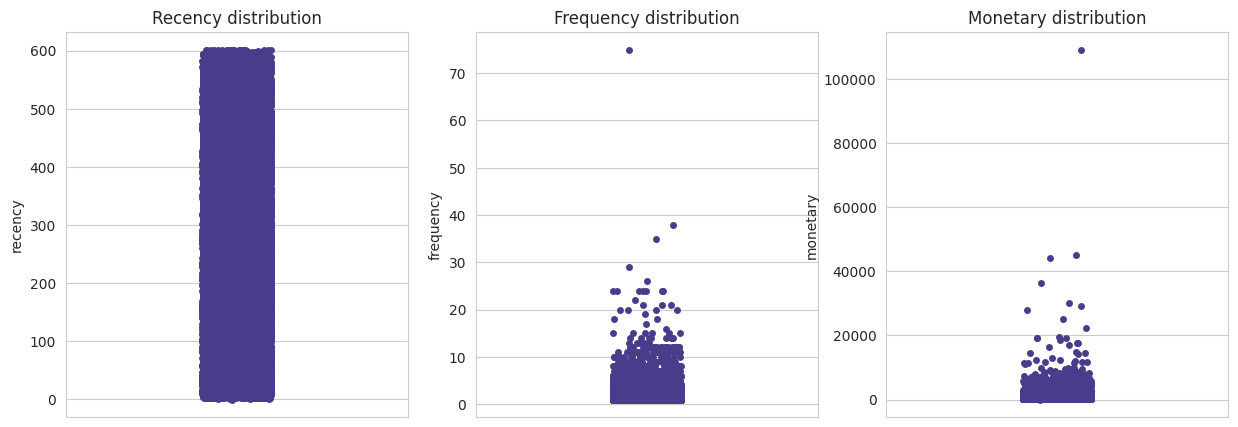

In [25]:
plot_RFM_distribution(customers_rfm_treated)

### Recency, Frequency and Monetary scores

The scores for each parameter will be calculated based on the quintiles of the values. The scores will range from 1 to 5, with 5 being the best score.
After that, the RFM score is given by:

$RFM\_score= 100*recency\_score + 10*frequency\_score + monetary\_score$


In [26]:
# for r_score, the lower the recency, the better
customers_rfm_treated['r_score'] = pd.qcut(customers_rfm_treated['recency'], q=5, labels=[5, 4, 3, 2, 1]).astype(int)
# for f_score, it's necessary to rank the values first, because there are many repeated values
customers_rfm_treated['f_score'] = pd.qcut(customers_rfm_treated['frequency'].rank(method= 'first'), 5, [1, 2, 3, 4, 5]).astype(int)
customers_rfm_treated['m_score'] = pd.qcut(customers_rfm_treated['monetary'], q=5, labels=[1, 2, 3, 4, 5]).astype(int)

# calculating the RFM score
customers_rfm_treated['RFM'] = 100*customers_rfm_treated['r_score'] + 10*customers_rfm_treated['f_score'] + customers_rfm_treated['m_score']
customers_rfm_treated.sample(5)

,recency,frequency,monetary,r_score,f_score,m_score,RFM
customer_unique_id,,,,,,,
25fd9d8e0233e89fb0e78895cef2aa2f,285,2,709.24,2,5,5,255
cf67e25021c5d2d3be45274bb18c1b08,276,1,92.68,2,4,3,243
be348ff0d3082bde9319e803d3312fb1,277,1,249.08,2,4,5,245
8e59b516ce4d23ed2e581bc130aeb0d3,166,1,52.78,4,3,1,431
4c7c157b7ca1593ff4b83309db3a3255,585,1,200.45,1,2,4,124


### Customer Segmentation

The customer segmentation will be done based on the RFM score. The customers will be divided into the following segments:

| Client Segment       | Behavior                                                                   | Potential Strategies                                                                                                               |
|----------------------|----------------------------------------------------------------------------|-------------------------------------------------------------------------------------------------------------------------------------|
| Champion             | Completed a recent purchase. They buy frequently and spend the most.       | Reward them. Can be early adopters of new products. They act as brand ambassadors.                                                  |
| Loyal Customer       | They buy frequently and spend a lot of money on the site. Sensitive to offers. | Upsell. Offer high-value items to them. Ask them for reviews. Build loyalty.                                                        |
| Potential Loyalist   | They recently spent a fair amount of money on the site more than once.     | Invite them to join a loyalty program or to get a membership. Recommend other products to them.                                     |
| New Customer         | Completed a recent purchase, but doesn’t order often.                      | Support them on their onboarding process. Get their satisfaction. Start to build loyalty.                                          |
| Promising            | Completed a recent purchase, but didn’t spend a lot.                       | Create brand awareness. Offer discounts, gifts and free trials.                                                                      |
| Need Attention       | Above average in recency, frequency and monetary value, but no recent purchases. | Launch limited-time offers and recommendations based on previous orders. Reactivate.                                              |
| Cannot Lose Them     | Completed huge, frequent purchases long ago but haven’t come back since then.| Get them back with new product launches. Don’t let competitors take them. Talk to them.                                            |
| About To Sleep       | Below average in recency, frequency and monetary value. At risk of losing them if you don’t reactivate. | Share useful information. Recommend popular products to them. Offer new discounts. Reconnect.                                       |
| At Risk              | Completed big, frequent purchases long ago. You need to bring them back!     | Send personalized emails to reconnect with special offers. Share useful resources with them.                                         |
| Hibernating          | Their last purchase was long ago. The number of orders was small and the amounts spent low. | Offer relevant products and special discounts. Create brand value again.                                                           |
| Lost                 | Lowest scores in recency, frequency and monetary value.                     | Try to reactivate them with personalized campaigns. If it doesn’t work, ignore them.                                               |



The segments are defined based on the RFM score as follows:


| Client Segment       | RFM                                       |
|----------------------|-------------------------------------------|
| Champion             | 555, 554, 544, 545, 454, 455, 445         |
| Loyal Customer       | 543, 444, 435, 355, 354, 345, 344, 335    |
| Potential Loyalist   | 553, 551, 552, 541, 542, 533, 532, 531, 452, 451, 442, 441, 431, 453, 433, 432, 423, 353, 352, 351, 342, 341, 333, 323|
| New Customer         | 512, 511, 422, 421, 412, 411, 311         |
| Promising            | 525, 524, 523, 522, 521, 515, 514, 513,425,424, 413,414,415, 315, 314, 313|
| Need Attention       | 535, 534, 443, 434, 343, 334, 325, 324    |
| Cannot Lose Them     | 155, 154, 144, 214, 215, 115, 114, 113    |
| About To Sleep       | 331, 321, 312, 221, 213                   |
| At Risk              | 255, 254, 245, 244, 253, 252, 243, 242, 235, 234, 225, 224, 153, 152, 145, 143, 142, 135, 134, 133, 125, 124|
| Hibernating          | 332, 322, 231, 241, 251, 233, 232, 223, 332, 322, 231, 241, 251, 233, 232, 223, 222, 132, 123, 122, 212, 211|
| Lost                 | 111, 112, 121, 131, 141, 151              |

Source: https://connectif.ai/en/blog/what-are-rfm-scores-and-how-to-calculate-them/

In [27]:
def segment_from_rfm(rfm_score):
    segments = {
        'Champion': ['555', '554', '544', '545', '454', '455', '445'],
        'Loyal Customer': ['543', '444', '435', '355', '354', '345', '344', '335'],
        'Potential Loyalist': ['553', '551', '552', '541', '542', '533', '532', '531', '452', '451', '442', '441', '431', '453', '433', '432', '423', '353', '352', '351', '342', '341', '333', '323'],
        'New Customer': ['512', '511', '422', '421', '412', '411', '311'],
        'Promising': ['525', '524', '523', '522', '521', '515', '514', '513', '425', '424', '413', '414', '415', '315', '314', '313'],
        'Need Attention': ['535', '534', '443', '434', '343', '334', '325', '324'],
        'Cannot Lose Them': ['155', '154', '144', '214', '215', '115', '114', '113'],
        'About To Sleep': ['331', '321', '312', '221', '213'],
        'At Risk': ['255', '254', '245', '244', '253', '252', '243', '242', '235', '234', '225', '224', '153', '152', '145', '143', '142', '135', '134', '133', '125', '124'],
        'Hibernating': ['332', '322', '231', '241', '251', '233', '232', '223', '332', '322', '231', '241', '251', '233', '232', '223', '222', '132', '123', '122', '212', '211'],
        'Lost': ['111', '112', '121', '131', '141', '151']
    }

    # convert to string if the RFM score is an integer
    if isinstance(rfm_score, int):
        rfm_score_str = str(rfm_score)

    for segment, scores in segments.items():
        if rfm_score_str in scores:
            return segment

    return 'Unknown'




In [28]:
customers_rfm_treated['customer_segment'] = customers_rfm_treated['RFM'].apply(segment_from_rfm)
customers_rfm_treated.sample(5)

,recency,frequency,monetary,r_score,f_score,m_score,RFM,customer_segment
customer_unique_id,,,,,,,,
3a05a8f6acc2a6eaa785b4a6511caa90,90,1,102.85,5,1,3,513,Promising
17c59808b63d2c77a6f31f8474ee38e2,381,2,56.60,2,5,2,252,At Risk
fb6fc7f6be4755fb126441994310fedd,279,1,216.64,2,5,4,254,At Risk
02961f000d03958b88e9cba0cf6253cb,34,1,249.89,5,1,5,515,Promising
813585153cd8b4b6c06e576d818ec985,343,1,72.75,2,3,2,232,Hibernating


In [29]:
summary_category(customers_rfm_treated, 'customer_segment')

,customer_segment,Count,%
0,Potential Loyalist,16414,17.138
1,At Risk,15453,16.135
2,Promising,11712,12.229
3,Hibernating,11449,11.954
4,Champion,7120,7.434
5,Cannot Lose Them,6516,6.804
6,Loyal Customer,6362,6.643
7,New Customer,5928,6.190
8,Need Attention,5743,5.996
9,Lost,4911,5.128


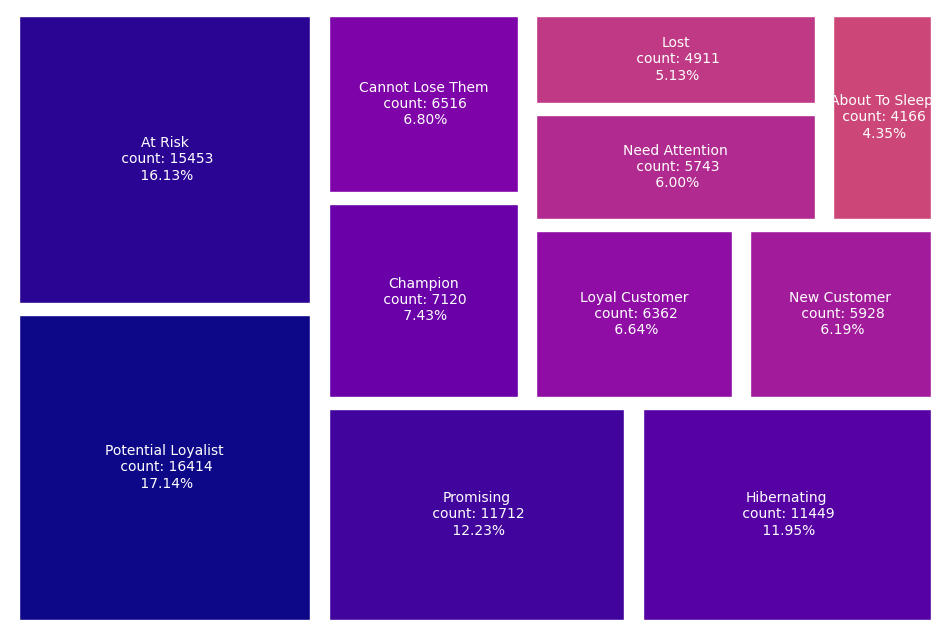

In [30]:
import matplotlib.pyplot as plt
import squarify

# Use squarify to plot the treemap of the segments
plt.figure(figsize=(12, 8))

# Data
segment_counts = customers_rfm_treated['customer_segment'].value_counts()
total = segment_counts.sum()
labels = [f'{segment}\n count: {count}\n {count/total:.2%}' for segment, count in segment_counts.items()]
values = segment_counts.values

# Define colors
colors = plt.cm.plasma(np.linspace(0, 0.5, len(labels)))

# Treemap
squarify.plot(sizes = values, label = labels, color = colors,
              pad = 0.1,
              text_kwargs = {'fontsize': 10, 'color': 'white'}
              )

# Remove the axis:
plt.axis("off")

plt.show()

In [31]:
# Compute mean stats on the customers_rfm_treated, grouped by the customer_segment
customers_rfm_treated.groupby('customer_segment').agg({'recency': 'mean', 'frequency': 'mean', 'monetary': 'mean'}).sort_values('recency')

,recency,frequency,monetary
customer_segment,,,
Champion,87.358989,2.072893,577.445733
Promising,105.551656,1.000000,214.102941
New Customer,124.523279,1.000000,53.328639
Potential Loyalist,131.297734,1.130925,76.150838
Need Attention,159.094028,1.000000,216.613643
Loyal Customer,181.792832,1.568532,401.737014
About To Sleep,257.189150,1.000000,60.235874
Hibernating,336.466678,1.016770,72.866734
At Risk,382.054617,1.356565,307.985073


## Distribution of Customer segments over geographic regions

This analysis will show the distribution of the customer segments by RFM over the geographic regions.

In [32]:
customers_region_ds  = customers_ds.merge(brazil_regions, left_on='customer_state', right_on='uf', how='left')
customers_region_ds.sample(3)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,uf,state_name,region
61654,6b7c4885e1dd12bd058d809f39e2d660,5ed603e92ce43d47e8f3a5ec4b1746d4,33040,santa luzia,MG,MG,Minas Gerais,Sudeste
68642,19792d55f9db2e2fb3864dc90966eb86,9cf60f4109040cf85537b7e9d4f91af9,36045,juiz de fora,MG,MG,Minas Gerais,Sudeste
48991,ddc14377d542cc888baf7ed3e4df1a77,cca180c80d52d242fca3ed8cfcefad09,92425,canoas,RS,RS,Rio Grande do Sul,Sul


In [33]:
# Grouping customers by region and segment
customers_rfm_region = customers_rfm_treated.merge(customers_region_ds[['customer_unique_id', 'region']], on='customer_unique_id', how='inner').drop_duplicates()
customers_rfm_region.sample(3)

,customer_unique_id,recency,frequency,monetary,r_score,f_score,m_score,RFM,customer_segment,region
10480,1ae15ac704d32a9ea9f2e1570404d1c8,562,1,60.77,1,1,2,112,Lost,Centro-Oeste
80261,cf1f61d8d459d90e800e9cccc9157373,78,1,51.03,5,4,1,541,Potential Loyalist,Nordeste
36791,5ebe8ca3c0fdd3ba40a4cac58da4260c,335,1,148.28,2,2,4,224,At Risk,Sudeste


Let's plot a barchart for each region to show us the distribution of the segments

In [34]:

def plot_categorical_distribution(df, cat_var1, cat_var2, subplot_layout, fig_size):
    """
      Plot the distribution of a categorical variable over a second categorical variable.

      Parameters
      ----------
        df : pandas.DataFrame
            The DataFrame containing the data.
        cat_var1 : str
            The name of the first categorical variable.
        cat_var2 : str
            The name of the second categorical variable.
        subplot_layout : tuple
            The layout of the subplots (rows, columns).
        fig_size : tuple
            The size of the figure.

        Returns
        -------
        None

    """
    # Unique list of categories for the first variable
    categories = df[cat_var1].unique()

    # Create a new figure
    fig, axs = plt.subplots(*subplot_layout, figsize=fig_size)

    # Calculate the total count of instances for each category of the first variable
    total_counts = df[cat_var1].value_counts()

    # Iterate over the categories
    for i, category in enumerate(categories):
        # Filter the DataFrame for the current category
        df_category = df[df[cat_var1] == category]

        # Create a bar plot for the current category
        ax = sns.countplot(data=df_category, x=cat_var2, ax=axs[i//subplot_layout[1], i%subplot_layout[1]], order=df_category[cat_var2].value_counts().index)

        # Set the title of the subplot
        ax.set_title(f'Distribution of {cat_var2} in {cat_var1} {category}')
        ax.set_xlabel(cat_var2)
        ax.set_ylabel('Count')
        ax.tick_params(axis='x', rotation=45)  # Rotate the labels on the x-axis

        # Add the percentage annotation above each bar
        for p in ax.patches:
            height = p.get_height()
            ax.text(p.get_x()+p.get_width()/2.,
                    height + 3,
                    '{:1.2f}%'.format(height/total_counts[category]*100),  # Add the percentage symbol here
                    ha="center")

    # Remove the last empty subplot if the number of subplots is more than the number of categories
    if len(categories) < subplot_layout[0] * subplot_layout[1]:
        fig.delaxes(axs[subplot_layout[0]-1, subplot_layout[1]-1])

    # Adjust the layout to avoid overlaps
    plt.tight_layout()
    plt.show()


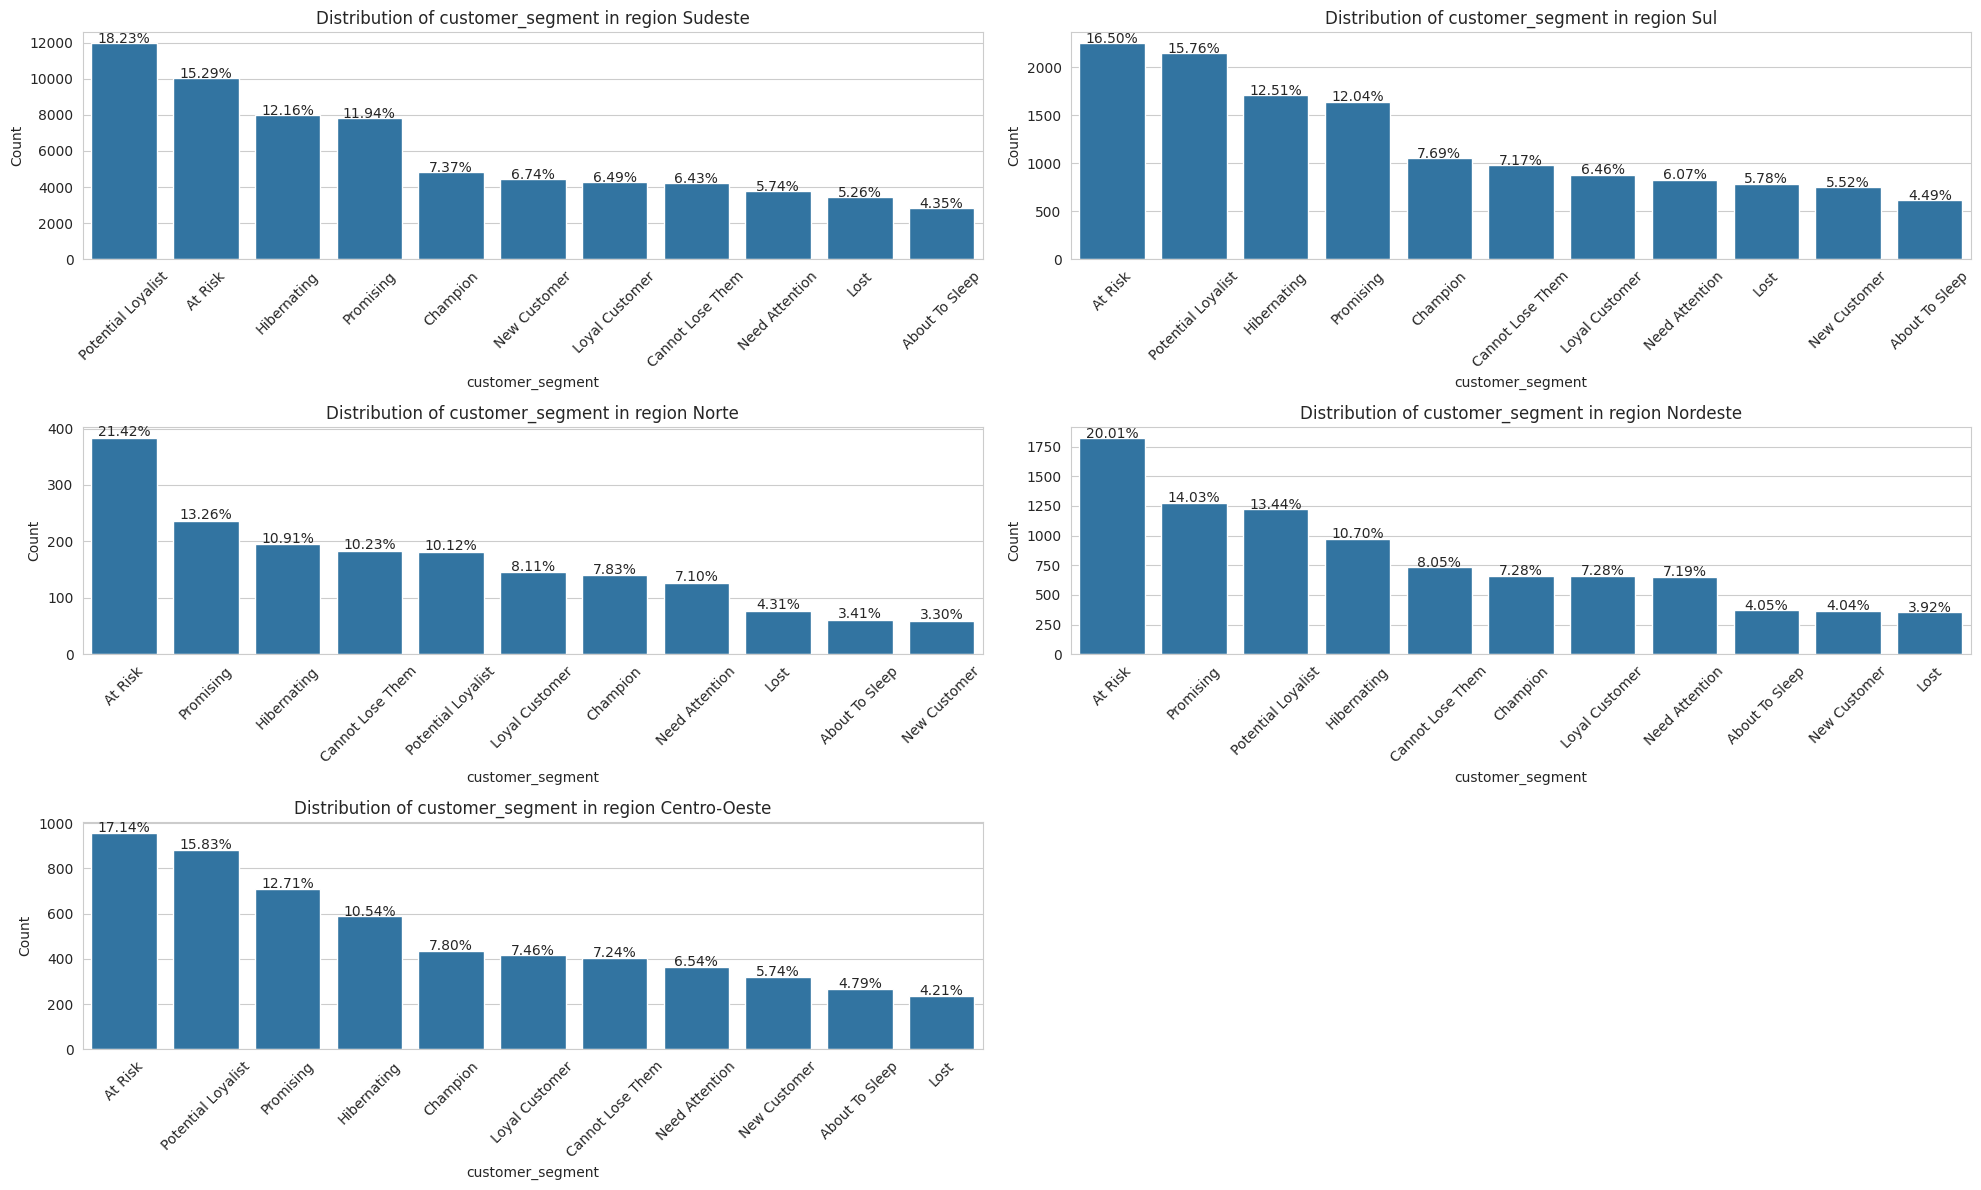

In [35]:
plot_categorical_distribution(customers_rfm_region, 'region', 'customer_segment', (3, 2), (20, 12))
## Automatic clustering


### Score for region strenght

To calculate the score for region strenght, we will consider the sum of the orders in each region.

In [36]:
# count the orders grouped by region
region_orders = order_merged_filtered.groupby('region').agg({'order_id': 'count'}).reset_index()
# rename the columns
region_orders.columns = ['region', 'count_region_orders']
region_orders['region_score'] = pd.qcut(region_orders['count_region_orders'], q=5, labels=[1, 2, 3, 4, 5]).astype(int)
region_orders

,region,count_region_orders,region_score
0,Centro-Oeste,6954,2
1,Nordeste,11038,3
2,Norte,2156,1
3,Sudeste,81681,5
4,Sul,16885,4


In [37]:
customers_rfm_region = customers_rfm_region.merge(region_orders[['region', 'region_score']], on='region', how='left')

In [38]:
customers_rfm_region.sample(3)

,customer_unique_id,recency,frequency,monetary,r_score,f_score,m_score,RFM,customer_segment,region,region_score
82131,db25a9f531ff466c85a6590f2ff635af,219,1,106.87,3,4,3,343,Need Attention,Sudeste,5
69294,b8df986511d928829c3192c2ed081eba,208,1,17.28,3,4,1,341,Potential Loyalist,Sudeste,5
47440,7e6b73ca13a846a38c86885e98a63ada,98,1,1349.16,4,3,5,435,Loyal Customer,Nordeste,3


In [39]:
# Compute mean stats on the customers_rfm_treated, grouped by the customer_segment
customers_rfm_region.groupby('customer_segment').agg({'recency': 'mean', 'frequency': 'mean', 'monetary': 'mean', 'RFM': 'mean', 'region_score': 'mean'}).sort_values('recency')

,recency,frequency,monetary,RFM,region_score
customer_segment,,,,,
Champion,87.329547,2.075025,577.246793,507.610153,4.405413
Promising,105.551656,1.000000,214.102941,452.114754,4.379013
New Customer,124.523279,1.000000,53.328639,426.753711,4.547065
Potential Loyalist,131.291684,1.130978,76.154213,443.158026,4.514468
Need Attention,159.094028,1.000000,216.613643,408.584538,4.348598
Loyal Customer,181.820267,1.568735,401.676322,393.354438,4.366064
About To Sleep,257.189150,1.000000,60.235874,281.769563,4.425108
Hibernating,336.466678,1.016770,72.866734,219.544764,4.458643
At Risk,382.032216,1.357161,307.973151,199.689934,4.334067


## Considerations

---
# Stage 3 - Products recommendation
---

## Colaborative Filtering using Matrix Factorization

Matrix factorization is a class of collaborative filtering algorithms used in recommender systems. Matrix factorization algorithms work by decomposing the user-item interaction matrix into the product of two lower dimensionality rectangular matrices. The user-item interaction matrix is a matrix where each row represents a user, each column an item. The value at the intersection of row i and column j is the rating user i gave to item j.

### Building the user-item matrix (embeddings)

Here we will build three user-item matrices with different types of ratings: the number of orders, the product rating and the product relevance, embedded by the number of orders, the product rating and the RFM score of the customer.

#### Purchase count matrix

This DataFrame summarizes how many times each customer has purchased each product. It normalizes these counts to the range of 0 to 1. This can be useful for understanding customer buying habits and making product recommendations.

In [40]:
def create_puchase_count_df(data):
    """
    Create a purchase count DataFrame.

    This function takes in a DataFrame `data` and performs the following steps:
    1. Sets the index of the DataFrame as 'customer_unique_id'.
    2. Applies the 'pd.Series' function to the 'product_id' column.
    3. Resets the index and melts the DataFrame to transform it from wide to long format.
    4. Drops any rows with missing values and the 'variable' column.
    5. Groups the DataFrame by 'customer_unique_id' and 'product_id' and calculates the count of each product.
    6. Renames the 'product_id' column to 'estimator'.
    7. Resets the index of the DataFrame.

    After performing the above steps, the function scales the 'estimator' column using MinMaxScaler,
    fills any missing values with 0.0, and returns the resulting DataFrame.

    Parameters:
    - data (DataFrame): The input DataFrame containing the data.

    Returns:
    - purchase_counts (DataFrame): The resulting DataFrame with purchase counts.

    """
    purchase_counts = (
        data.set_index('customer_unique_id')['product_id']
        .apply(pd.Series)
        .reset_index()
        .melt(id_vars=['customer_unique_id'], value_name='product_id')
        .dropna()
        .drop(['variable'], axis=1)
        .groupby(['customer_unique_id', 'product_id'])
        .agg({'product_id': 'count'})
        .rename(columns={'product_id': 'estimator'})
        .reset_index()
    )

    scaler = MinMaxScaler()
    purchase_counts[['estimator']] = scaler.fit_transform(purchase_counts[['estimator']])
    purchase_counts['estimator'] = purchase_counts['estimator'].fillna(0.0)

    return purchase_counts


In [41]:
purchase_counts = create_puchase_count_df(order_merged_delivered)
purchase_counts.sample(3)

,customer_unique_id,product_id,estimator
33377,55e2a75ae371722e048b5e9ef87e83c3,94bb0da423501924c41368236d88e808,0.0
73796,bda6b1a673bc84ea9e8034ac152ccd26,7dc6f855494bc660c8ff01686446a69f,0.0
67712,ae120a3b9a0e9628f5f08781b0cdf895,3dd2a17168ec895c781a9191c1e95ad7,0.0


#### Product rating matrix

In [42]:
def create_review_score_df(data):
    """
    Create a dataframe with the average review score for each customer and product combination.

    Parameters:
        data (pandas.DataFrame): The input dataframe containing customer, product, and review score information.

    Returns:
        pandas.DataFrame: A dataframe with columns 'customer_unique_id', 'product_id', and 'estimator',
        where 'estimator' represents the average review score for each customer and product combination.
    """

    user_prod_reviewscore = (
        data.groupby(['customer_unique_id','product_id'])['review_score']
        .mean()
        .reset_index()
        .rename(columns={'review_score':'estimator'})
    )

    scaler = MinMaxScaler()
    user_prod_reviewscore['estimator'] = scaler.fit_transform(user_prod_reviewscore[['estimator']])
    user_prod_reviewscore['estimator'] = purchase_counts['estimator'].fillna(0.0)

    return user_prod_reviewscore

In [43]:
user_prod_reviewscore = create_review_score_df(order_merged_delivered)


#### Product relevance and RFM score matrix

Embedding the product rating and the product purchase count by the RFM score of the customer. The final estimator is a score defined by : 

$estimator = 0.8*product\_count + 0.15*mean\_review +  0.05*RFM\_score$

All the values are normalized to the range of 0 to 1 before the computing. 

In [44]:

def create_product_relevance_score(purchase_counts, user_prod_reviewscore, customers_rfm):
    """
    Calculates the relevance score for each product based on purchase counts, user product review scores, and RFM values.

    Parameters
    ----------
        purchase_counts (DataFrame): DataFrame containing purchase counts for each customer and product.
        user_prod_reviewscore (DataFrame): DataFrame containing user product review scores for each customer and product.
        customers_rfm (DataFrame): DataFrame containing RFM values for each customer.

    Returns
    --------
        purchase_counts_relevance (DataFrame): DataFrame containing the relevance score for each customer and product.
        purchase_counts_rmf (DataFrame): DataFrame containing the normalized purchase counts, mean review scores, and RFM values for each customer and product.
    """
    # Rename column to avoid conflicts
    purchase_counts_ = purchase_counts.rename(columns={'estimator': 'purchase_counts'})
    user_prod_reviewscore_ = user_prod_reviewscore.rename(columns={'estimator': 'mean_review'})

    # Merge the two DataFrames
    merged = purchase_counts_.merge(user_prod_reviewscore_, on=['customer_unique_id', 'product_id'], how='left')

    # customers_rfm_ = customers_rfm.reset_index()
    purchase_counts_rmf = merged.merge(customers_rfm[['customer_unique_id', 'RFM']].reset_index(), on='customer_unique_id', how='left')
    purchase_counts_rmf.drop('index', axis=1, inplace=True)
    purchase_counts_rmf['mean_review'].fillna(0.0, inplace=True)

    scaler = MinMaxScaler()
    purchase_counts_rmf[['purchase_counts', 'mean_review', 'RFM']] = scaler.fit_transform(purchase_counts_rmf[['purchase_counts', 'mean_review', 'RFM']])
    purchase_counts_rmf['estimator'] = 0.8*purchase_counts_rmf['purchase_counts'] + 0.175*purchase_counts_rmf['mean_review'] + 0.025*purchase_counts_rmf['RFM']
    purchase_counts_relevance = purchase_counts_rmf[['customer_unique_id', 'product_id', 'estimator']]
    purchase_counts_relevance['estimator'].fillna(0.0, inplace=True)

    return purchase_counts_relevance, purchase_counts_rmf

In [45]:
product_relevance, purchase_counts_rmf = create_product_relevance_score(purchase_counts, user_prod_reviewscore, customers_rfm_region)
product_relevance.sample(3)

/tmp/ipykernel_66528/92545177.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  purchase_counts_relevance['estimator'].fillna(0.0, inplace=True)


,customer_unique_id,product_id,estimator
6593,10db098f009507e2269cdee581d5a0e6,b833b995caddd97b8786370988e32ee4,0.007939
59336,98ad94d03d6f208e424207d61e3b4540,79e98bde1cf4a5e68c97cfd1872de142,0.018018
94693,f35271305526691e8269aa4a915e56a2,202bd859659a841de892b00c341300ff,0.002421


### Model and embedding selection

In this section we will select the best model and embedding for the recommendation system. We will use the matrix factorization algorithm to predict the score of the products for each customer using SVD, and evaluate the performance of the model using the RMSE metric.

For this, we'll set a baseline model `NormalPredictor` to compair against the SVD. The NormalPredictor predicts a random score based on the distribution of the training set, which is useful to compare the performance of the SVD model. 

In [46]:
from surprise import NormalPredictor, Reader, Dataset, accuracy, SVD, SVDpp
from surprise.model_selection import cross_validate, KFold, GridSearchCV, train_test_split

def build_train_dataset(data):
    """
    Builds and returns a training dataset for the recommendation system.

    Parameters:
    - data: pandas DataFrame containing the customer unique IDs, product IDs, and estimators.

    Returns:
    - df: Surprise Dataset object containing the training dataset.
    """

    scale = (data.estimator.min(), data.estimator.max())
    reader = Reader(rating_scale=scale)

    df = Dataset.load_from_df(data[['customer_unique_id','product_id','estimator']], reader)

    return df


def multiple_training(train_data, params=None):
    """
    Perform model training and evaluation using the given train_data.

    Parameters:
    - train_data (pandas.DataFrame): The training dataset.

    Returns:
    - pandas.DataFrame: A DataFrame containing the mean RMSE values for the baseline and SVD models.

    """

    test_df = build_train_dataset(train_data)

    normp_rmse, svd_rmse, svdpp_rmse= [], [], []
    kf = KFold(n_splits=5, shuffle=True, random_state=19)
    
    # set a seed 
    np.random.seed(19)

    for trainset, testset in kf.split(test_df): 

        #baseline
        normp = NormalPredictor()
        normp.fit(trainset)
        normp_pred = normp.test(testset)
        normp_rmse.append(accuracy.rmse(normp_pred,verbose=False))

        params = {'n_factors': 30, 'n_epochs': 50, 'lr_all': 0.001, 'reg_all': 0.4}
        svd = SVD(
            n_factors=params['n_factors'],
            n_epochs=params['n_epochs'],
            lr_all=params['lr_all'],
            reg_all=params['reg_all']
        )

        svd.fit(trainset)
        svd_pred = svd.test(testset)
        svd_rmse.append(accuracy.rmse(svd_pred,verbose=False))
        
        svdpp = SVDpp(
            n_factors=params['n_factors'],
            n_epochs=params['n_epochs'],
            lr_all=params['lr_all'],
            reg_all=params['reg_all']
        )

        svdpp.fit(trainset)
        svdpp_pred = svdpp.test(testset)
        svdpp_rmse.append(accuracy.rmse(svdpp_pred,verbose=False))

    mean_rmses = [np.mean(normp_rmse),
                  np.mean(svd_rmse),
                  np.mean(svdpp_rmse)
                  ]

    model_names = ['baseline', 'svd', 'svdpp']
    compare_df = pd.DataFrame(mean_rmses, index=model_names)

    return compare_df


def comparasion(embeddings, embeddings_names, params=None):
    """
    Compare different methods by creating a dataframe with their results.

    Parameters:
    embeddings (list): A list of methods to compare.

    Returns:
    None
    """
    comp_matrix = multiple_training(embeddings[0], params=params).transpose()
    print('Initial dataframe created.')

    for method in embeddings[1:]:
        temp_df = multiple_training(method).transpose()
        comp_matrix = pd.concat((comp_matrix,temp_df), axis=0)
        print("Layer added to dataframe.")

    comp_matrix = comp_matrix.set_index([embeddings_names])
    
    return comp_matrix


In [47]:
# Run 
embeddings = [purchase_counts, user_prod_reviewscore, product_relevance]
embeddings_names = ['purchase_counts', 'user_prod_reviewscore', 'product_relevance']
comparison = comparasion(embeddings, embeddings_names)
# Calculate the percentual difference
comparison['percentual_diff_svd'] = 100*(comparison['baseline'] - comparison['svd'])/comparison['baseline']
comparison['percentual_diff_svdpp'] =100*(comparison['baseline'] - comparison['svdpp'])/comparison['baseline']


Initial dataframe created.
Layer added to dataframe.
Layer added to dataframe.


In [48]:
comparison

,baseline,svd,svdpp,percentual_diff_svd,percentual_diff_svdpp
purchase_counts,0.020119,0.018103,0.020273,10.021915,-0.764174
user_prod_reviewscore,0.020119,0.018103,0.020273,10.021915,-0.764174
product_relevance,0.023631,0.019673,0.021890,16.751080,7.368847


The best model and embedding combination is SVD using user_prod_reviewscore embedding, when it is compaired to the its baseline. However, the best combination in terms of the difference of RMSE is the SVD using the product_relevance embedding.

#### Model Tunning

In order to improve the performance of the model, we can tune the hyperparameters of the SVD model using the GridSearchCV method.

In [49]:
def gridsearch(data, model, param_grid, njobs=4):
    """
    Perform grid search to find the best hyperparameters for a given model.

    Parameters:
    - data: The input data for training the model.
    - model: The machine learning model to be trained.
    - param_grid: The grid of hyperparameters to be searched.
    - njobs: The number of parallel jobs to run during grid search.

    Returns:
    - new_params: The best hyperparameters found during grid search.
    - best_score: The best score achieved by the model.

    """
    param_grid = param_grid
    gs = GridSearchCV(model, param_grid, measures=['rmse'], cv=5, n_jobs=njobs)
    gs.fit(data)

    new_params = gs.best_params['rmse']
    best_score = gs.best_score['rmse']

    print("Best score:", best_score)
    print("Best params:", new_params)

    return new_params, best_score

def run_grid_search(df, svd_param_grid, njobs=8):
    
    data = build_train_dataset(purchase_counts)
    new_params, best_score = gridsearch(data, SVD, svd_param_grid, njobs)
    
    return new_params, best_score


In [50]:
svd_param_grid = {
    'n_factors': [25,50,100],
    'n_epochs': [20,30,50],
    'lr_all': [0.002,0.005,0.01],
    'reg_all':[0.02,0.1,0.4, 0.5]
}

In [51]:


# new_params, best_score = run_grid_search(purchase_counts, svd_param_grid, 8)

In [52]:
# new_params, best_score = run_grid_search(user_prod_reviewscore, svd_param_grid, 8)

In [53]:
# new_params, best_score = run_grid_search(product_relevance, svd_param_grid, 8)

The tunning improved the the model using product_relevance embeddings, achieving the lower RMSE. So that, the best model is the SVD using the product_relevance embedding.

### Model training 

In [54]:
def build_train_dataset(data):
    """
    Builds and returns a training dataset for the recommendation system.

    Parameters:
    - data: pandas DataFrame containing the customer unique IDs, product IDs, and estimators.

    Returns:
    - df: Surprise Dataset object containing the training dataset.
    """

    scale = (data.estimator.min(), data.estimator.max())
    reader = Reader(rating_scale=scale)

    df = Dataset.load_from_df(data[['customer_unique_id','product_id','estimator']], reader)

    return df


def final_model(data, params=None):
    """
    This function trains the final model using the SVD algorithm from the Surprise library.
    It takes as input a DataFrame with the user-item interactions and a dictionary with the hyperparameters for the SVD model.
    It returns the predictions of the model, the RMSE of the predictions and the training set.

    Parameters:
    - data (pandas.DataFrame): DataFrame containing the user-item interactions. It should have three columns: 'customer_unique_id', 'product_id', 'estimator'.
    - params (dict, optional): Dictionary containing the hyperparameters for the SVD model. If not provided, it uses default values.

    Returns:
    - predictions (list of Prediction objects): The list of predictions of the model.
    - rmse (float): The root mean square error of the predictions.
    - train_set (Trainset): The training set.
    """

    # Build the training dataset
    user_products_estimator_matrix = build_train_dataset(data)

    # Split the dataset into training and test sets
    train_set, test_set = train_test_split(user_products_estimator_matrix, test_size=0.2, random_state=19)

    # If no parameters are provided, use default values
    if params is None:
        params = {'n_factors': 25, 'n_epochs': 50, 'lr_all': 0.01, 'reg_all': 0.4}

    # Initialize the SVD model with the given parameters
    svd = SVD(n_factors=params['n_factors'],
                n_epochs=params['n_epochs'],
                lr_all=params['lr_all'],
                reg_all=params['reg_all'])

    # Fit the model to the training set
    svd.fit(train_set)

    # Make predictions on the test set
    predictions = svd.test(test_set)

    # Calculate the RMSE of the predictions
    rmse = accuracy.rmse(predictions,verbose=False)

    return predictions, rmse, train_set

final_predictions, final_rmse, train_set = final_model(product_relevance)

In [56]:

params = {'n_factors': 25, 'n_epochs': 70, 'lr_all': 0.01, 'reg_all': 0.5}
final_predictions, final_rmse, train_set = final_model(product_relevance, params)

In [ ]:
final_rmse

### Error analysis

In [57]:

def get_Iu(uid):
    """Return the number of items rated by given user

    Args:
        uid: The raw id of the user.
    Returns:
        The number of items rated by the user.
    """

    try:
        return len(train_set.ur[train_set.to_inner_uid(uid)])
    except ValueError:  # user was not part of the trainset
        return 0

def get_Ui(iid):
    """Return the number of users that have rated given item

    Args:
        iid: The raw id of the item.
    Returns:
        The number of users that have rated the item.
    """

    try:
        return len(train_set.ir[train_set.to_inner_iid(iid)])
    except ValueError:  # item was not part of the trainset
        return 0

r

In [58]:
recommendation_results = pd.DataFrame(final_predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
recommendation_results['Iu'] = recommendation_results.uid.apply(get_Iu)
recommendation_results['Ui'] = recommendation_results.iid.apply(get_Ui)
recommendation_results['err'] = abs(recommendation_results.est - recommendation_results.rui)

recommendation_results.rename(
    columns={
        'uid': 'customer_unique_id',
        'iid': 'product_id',
        'rui': 'estimator',
        'est': 'prediction',
        'Iu': 'n_ratings_by_user',
        'Ui': 'n_ratings_of_product'
    }, inplace=True

)

recommendation_results.sample(5)

,customer_unique_id,product_id,estimator,prediction,details,n_ratings_by_user,n_ratings_of_product,err
11396,d96c70c50983a6a7b4af3177a40897f0,3e34352aa9c04170d941a9a8c6a895bb,0.024324,0.001306,{'was_impossible': False},0,2,0.023018
6117,77d5ea1cb78d945a5bf7589b64323478,7fb04722aba7a2b632bac8f9819796f3,0.006306,0.015217,{'was_impossible': False},0,58,0.008911
11893,37cc82160685ecacbee8ea034056ae44,3b60d513e90300a4e9833e5cda1f1d61,0.011430,0.015721,{'was_impossible': False},0,20,0.004291
16710,19e5b71b7be85c9d54c418dfb4088614,04f92f94955d380b722ed941f2e6e51c,0.022748,0.016510,{'was_impossible': False},0,0,0.006238
17169,f5fe2cb2baa77eac7538198feb651412,11875b30b49585209e608f40e8082e65,0.002365,0.011394,{'was_impossible': False},0,46,0.009029


#### Error distribution

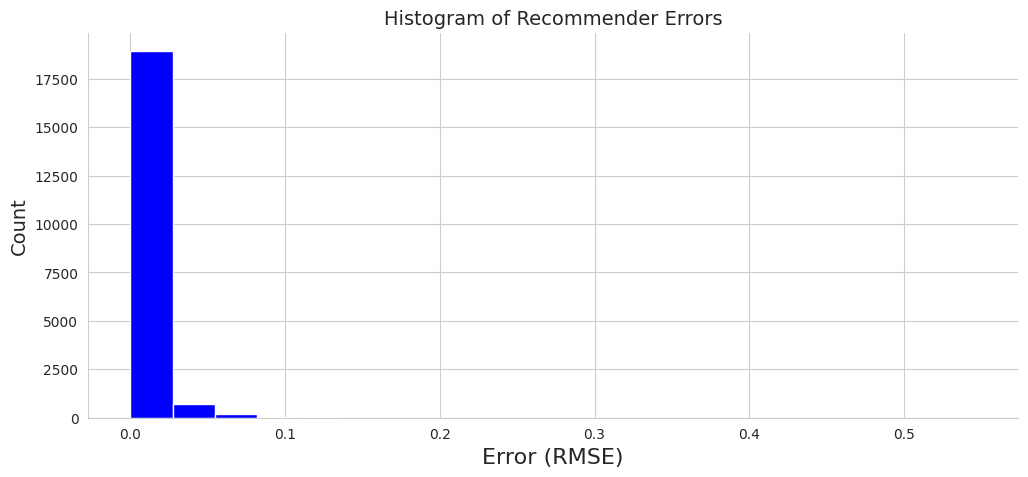

In [60]:

plt.figure(figsize=(12,5))
plt.hist(recommendation_results.err, color='blue', bins=20)
plt.xlabel('Error (RMSE)', size=16)
plt.ylabel('Count', size=14)
plt.title('Histogram of Recommender Errors', size=14)
sns.despine();

#### Best and worst predictions

In [61]:
best_predictions = recommendation_results.sort_values(by='err')[:10]
best_predictions

,customer_unique_id,product_id,estimator,prediction,details,n_ratings_by_user,n_ratings_of_product,err
12230,092d9a82f879163bc21cc66a73145b96,30d55419015a4d9c2ca68586923d5a9f,0.000000,0.000000,{'was_impossible': False},0,3,0.000000e+00
3106,1b51e96350d407160fd2d2449c59ecf8,f7d4df9b0dceb85f4a856cd61da67ecd,0.000000,0.000000,{'was_impossible': False},0,1,0.000000e+00
5670,bcbe49135a6214760ea6ac719e45e765,af0a99476d96dcc1a1baa7c0d9ff6b9d,0.018806,0.018806,{'was_impossible': False},0,18,5.741792e-07
3852,c55641c7b843c3e7baae66b5946cdbb8,c8c073a1cae6a98799d7581958ede514,0.013176,0.013175,{'was_impossible': False},0,5,7.752120e-07
10140,9c8cd7e1a0a0224f2846f8766eb1c6ee,b0c8da302d49498d2ce6be8c631e4e20,0.023705,0.023704,{'was_impossible': False},0,20,1.268075e-06
14953,ca6a81ca06a8d538dee02d3ce5c0d23e,0ec7b6a863e219792bc4d50d3a62a839,0.018750,0.018746,{'was_impossible': False},0,10,3.940217e-06
4788,dce5c2ba30e0cdab93060715a2f7dafb,0ec7b6a863e219792bc4d50d3a62a839,0.018750,0.018746,{'was_impossible': False},0,10,3.940217e-06
393,af2cd67b99b50a0d167f448681d6c3a5,4fe644d766c7566dbc46fb851363cb3b,0.018131,0.018137,{'was_impossible': False},0,77,6.320303e-06
8024,843c7e9e24758cfbc00dd941be3de79b,4fe644d766c7566dbc46fb851363cb3b,0.018131,0.018137,{'was_impossible': False},0,77,6.320303e-06
11131,df02a4f7f01b9bb9ae11fcc020d78de0,fb979d44fd4269b2ea30e300b66c89f3,0.025000,0.025007,{'was_impossible': False},0,2,6.931973e-06


In [62]:
worst_predictions = recommendation_results.sort_values(by='err')[-10:]
worst_predictions

,customer_unique_id,product_id,estimator,prediction,details,n_ratings_by_user,n_ratings_of_product,err
6568,a5d3bfee5b23b430b95c4ae295e1028a,7c68e7297c7df2535c9f0dcd61007f64,0.216502,0.011871,{'was_impossible': False},1,0,0.204631
19153,98dbf8eb4655115b637a4932f71b0b72,60ee9861f35c13d4a3a2bc10e86bb05b,0.222132,0.009700,{'was_impossible': False},0,2,0.212432
14447,c411c8b6dbaffd467263f87a23f2cf52,87dc701592a3d9c9b7b02e6b004f7764,0.275268,0.056773,{'was_impossible': False},1,1,0.218495
17875,a5c6335399140e986db84120c425adf0,32e18e89237933ebdaaebd78a27e7fa1,0.262805,0.027382,{'was_impossible': False},0,9,0.235423
5759,ae977f6cf6981d883940f7e618620b3e,dd8e3ce8409dea51c566f227a4fc34ba,0.275155,0.016510,{'was_impossible': False},0,0,0.258645
3656,c375736396906dff8414217e02c45661,9f1c3e71d56894398a42b050b07f1baa,0.280898,0.019436,{'was_impossible': False},0,14,0.261462
726,31e412b9fb766b6794724ed17a41dfa6,422879e10f46682990de24d770e7f83d,0.322885,0.018802,{'was_impossible': False},0,279,0.304083
1060,24f12460aad399ba18f4ed2c2fbab65d,777d2e438a1b645f3aec9bd57e92672c,0.430357,0.013745,{'was_impossible': False},0,72,0.416613
13524,c402f431464c72e27330a67f7b94d4fb,ee3d532c8a438679776d222e997606b3,0.465568,0.026301,{'was_impossible': False},0,6,0.439267
13820,c8460e4251689ba205045f3ea17884a1,e7cc48a9daff5436f63d3aad9426f28b,0.571951,0.025472,{'was_impossible': False},0,41,0.546479


#### Error by region, customer segment and product category


In [66]:
# Merge with customer_rfm
recommendation_results = recommendation_results.merge(customers_rfm_region[['customer_unique_id', 'region', 'customer_segment']], on='customer_unique_id', how='left')
recommendation_results = recommendation_results.merge(products_ds[['product_id', 'product_category_name']], on='product_id', how='left')


In [68]:
err_region = recommendation_results.groupby('region').agg({'err': 'mean'}).sort_values('err')
err_region

,err
region,
Nordeste,0.009787
Sudeste,0.009936
Norte,0.010012
Centro-Oeste,0.010138
Sul,0.010552


In [69]:
err_customer_segment = recommendation_results.groupby('customer_segment').agg({'err': 'mean'}).sort_values('err')
err_customer_segment

,err
customer_segment,
New Customer,0.004499
Need Attention,0.004716
Promising,0.004990
About To Sleep,0.006560
Potential Loyalist,0.007088
Hibernating,0.009678
Loyal Customer,0.010996
At Risk,0.012641
Lost,0.013276


In [70]:
err_category = recommendation_results.groupby('product_category_name').agg({'err': 'mean'}).sort_values('err')
err_category

,err
product_category_name,
portateis_cozinha_e_preparadores_de_alimentos,0.004230
livros_importados,0.004740
fraldas_higiene,0.004751
construcao_ferramentas_ferramentas,0.005048
tablets_impressao_imagem,0.006190
...,...
moveis_escritorio,0.015341
pc_gamer,0.015643
agro_industria_e_comercio,0.015975


In [ ]:
recommendation_results.loc[recommendation_results.uid=='cbd70d39b38dc382a7104dca8fa6ad28']
